In [ ]:
from datasets import load_dataset

ds = load_dataset("mteb/nsynth-mini")
print(ds)

In [ ]:
from datasets import DatasetDict, concatenate_datasets

all_data = concatenate_datasets([
    ds['train'], 
    ds['validation'], 
    ds['test']
])

all_data = all_data.shuffle(seed=7)

train_valid_test = all_data.train_test_split(train_size=7500, seed=7)

valid_test = train_valid_test['test'].train_test_split(test_size=0.5, seed=7)

final_dataset = DatasetDict({
    'train': train_valid_test['train'],
    'val': valid_test['train'],
    'test': valid_test['test']
})

print(final_dataset)


In [ ]:
def pad_or_trim_audio(example, target_length=8000):
    audio_array = example['audio']['array']
    
    if len(audio_array) > target_length:
        trimmed_array = audio_array[:target_length]
    else:
        pad_length = target_length - len(audio_array)
        trimmed_array = audio_array + [0.0] * pad_length

    example['audio']['array'] = trimmed_array
    return example

In [ ]:
target_length = 8000
trimmed_dataset = final_dataset.map(
    lambda x: pad_or_trim_audio(x, target_length=target_length),
)

In [ ]:
len(trimmed_dataset['train']['audio'][0]['array'])

In [ ]:
from IPython.display import Audio
Audio(trimmed_dataset['train']['audio'][0]['array'], rate=16000)

In [ ]:
trimmed_dataset

In [ ]:
trimmed_dataset['train']['audio']

In [ ]:
import pandas as pd

def extract_audio_pitch(ds_split):
    return pd.DataFrame({
        "audio": [item["array"] for item in ds_split["audio"]],
        "pitch": ds_split["pitch"]
    })

train_df = extract_audio_pitch(trimmed_dataset["train"])
val_df = extract_audio_pitch(trimmed_dataset["val"])
test_df = extract_audio_pitch(trimmed_dataset["test"])

In [ ]:
train_df

In [ ]:
print(train_df["pitch"].value_counts().sort_index())

In [2]:
import librosa
import numpy as np

def load_background_noises(filepaths, target_len=8000, sr=16000):
    noises = []
    for path in filepaths:
        noise, original_sr = librosa.load(path, sr=None)  # preserve original sr
        if original_sr != sr:
            noise = librosa.resample(noise, orig_sr=original_sr, target_sr=sr)
        if len(noise) < target_len:
            noise = np.pad(noise, (0, target_len - len(noise)))
        else:
            noise = noise[:target_len]
        noises.append(noise)
    return noises

In [4]:
noise_paths = ['/kaggle/input/new-noise/noise4.mp3', '/kaggle/input/noise-data/noise2.mp3', '/kaggle/input/noise-data/noise3.mp3']
noises = load_background_noises(noise_paths)

Note: Illegal Audio-MPEG-Header 0x00000000 at offset 45668.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
/tmp/ipykernel_36/910344721.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  noise, original_sr = librosa.load(path, sr=None)  # preserve original sr
/tmp/ipykernel_36/910344721.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  noise, original_sr = librosa.load(path, sr=None)  # preserve original sr
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 53972.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_36/910344721.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  noise, original_sr = librosa.l

In [9]:
from IPython.display import Audio
Audio(noises[2],rate = 16000)

In [10]:
Audio(noises[0],rate = 16000)

In [11]:
noises

[array([0.        , 0.        , 0.        , ..., 0.01104403, 0.01008505,
        0.01587473], dtype=float32),
 array([ 0.        ,  0.        ,  0.        , ..., -0.0203537 ,
        -0.01720928, -0.01334344], dtype=float32),
 array([ 0.        ,  0.        ,  0.        , ..., -0.02001333,
        -0.01491752, -0.01526523], dtype=float32)]

In [12]:
import librosa
import numpy as np

In [13]:
import pandas as pd
train_df = pd.read_pickle('/kaggle/input/audio-dataset/train_df.pkl')
test_df = pd.read_pickle('/kaggle/input/audio-dataset/test_df.pkl')
val_df = pd.read_pickle('/kaggle/input/audio-dataset/val_df.pkl')

In [14]:
def add_background_noise(audio, background_noises, noise_level=0.3):
    bg = background_noises[np.random.randint(len(background_noises))]
    bg = librosa.util.fix_length(bg, size = len(audio))
    return audio + noise_level * bg

def add_colored_noise(audio, noise_level=0.02, noise_type='white'):
    rng = np.random.default_rng()
    if noise_type == 'white':
        noise = rng.normal(0, 1, len(audio))
    elif noise_type == 'pink':
        # Approximate pink noise
        uneven = len(audio) % 2
        X = np.random.randn(len(audio) // 2 + 1 + uneven) + 1j * np.random.randn(len(audio) // 2 + 1 + uneven)
        S = np.abs(np.fft.rfftfreq(len(audio), d=1. / 16000))
        S = np.where(S == 0, 1, S)
        X = X / S**0.5
        y = np.fft.irfft(X).real
        noise = y[:len(audio)]
    elif noise_type == 'brown':
        noise = np.cumsum(rng.normal(0, 1, len(audio)))
        noise = noise / np.max(np.abs(noise))
    else:
        raise ValueError("Unknown noise type")

    noise = noise / np.std(noise)
    return audio + noise_level * noise


In [15]:
def add_noise(audio, background_noises):
    x = add_background_noise(audio, background_noises,
                         noise_level=np.random.uniform(0.2, 0.4))
    if np.random.rand() < 0.5:  # only 50% chance to apply
        x = add_colored_noise(x, noise_level=np.random.uniform(0.02, 0.04),
                              noise_type=np.random.choice(['white', 'pink', 'brown']))
    
    return x

In [16]:
def augment_audio(audio, pitch, background_noises):
    def safe_pitch(p): return np.clip(p, 1, 128)

    variants = []

    variants.append((audio, pitch))

    # 2. Original + noise
    x = add_noise(audio, background_noises)
    variants.append((x, pitch))


    # 3. Pitch +1 + noise
    x = librosa.effects.pitch_shift(audio, sr=16000, n_steps=+1)
    x = add_noise(x, background_noises)
    variants.append((x, safe_pitch(pitch + 1)))

    # 4. Pitch -1 + noise
    x = librosa.effects.pitch_shift(audio, sr=16000, n_steps=-1)
    x = add_noise(x, background_noises)
    variants.append((x, safe_pitch(pitch - 1)))

    # 5. Volume up + noise
    x = audio * 1.2
    x = add_noise(x, background_noises)
    variants.append((x, pitch))

    # 6. Volume down + noise
    x = audio * 0.8
    x = add_noise(x, background_noises)
    variants.append((x, pitch))

    return variants

In [17]:
def build_augmented_df(df, background_noises):
    new_rows = []

    for _, row in df.iterrows():
        audio = row["audio"]
        pitch = row["pitch"]
        augmented_versions = augment_audio(audio, pitch, background_noises)

        for audio_aug, pitch_aug in augmented_versions:
            new_rows.append({"audio": audio_aug, "pitch": pitch_aug})

    return pd.DataFrame(new_rows)

In [18]:
#sample = build_augmented_df(pd.DataFrame(train_df[0]), noises)

In [19]:
#for _, row in sample.iterrows():
#    Audio(row["audio"], rate = 16000)

In [20]:
train_augmented = build_augmented_df(train_df, noises)

In [21]:
train_augmented.shape

(45000, 2)

In [22]:
train_augmented

,audio,pitch
0,"[0.12640380859375, -0.626983642578125, 0.31561...",90
1,"[0.06613405293265351, -0.6189485129259907, 0.3...",90
2,"[0.011134175939929476, -0.5940430071812675, 0....",91
3,"[0.066969517838496, -0.6270906670121577, 0.142...",89
4,"[0.12002503651118965, -0.7991182614491262, 0.4...",90
...,...,...
44995,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",52
44996,"[-0.0020050909370183945, -0.002269711811095476...",53
44997,"[-0.023154599776025277, 0.06305262931735703, -...",51
44998,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",52


In [23]:
Audio(train_augmented['audio'][10], rate = 16000)

In [24]:
print(train_augmented["pitch"].value_counts())

pitch
61     676
62     672
63     664
75     664
48     660
      ... 
120      2
118      2
111      1
113      1
117      1
Name: count, Length: 112, dtype: int64


In [25]:
train_augmented = train_augmented[train_augmented["pitch"].between(21, 108)].reset_index(drop=True)
test_df = test_df[test_df["pitch"].between(21, 108)].reset_index(drop=True)
val_df = val_df[val_df["pitch"].between(21, 108)].reset_index(drop=True)

In [26]:
print(train_augmented["pitch"].min(), train_augmented["pitch"].max())
print(train_augmented.shape)

21 108
(44509, 2)


In [27]:
#train_augmented.to_pickle("train_augmented_withinPianoKeys.pkl")

In [28]:
train_augmented["pitch"] = train_augmented["pitch"] - 21
val_df["pitch"] = val_df["pitch"] - 21
test_df["pitch"] = test_df["pitch"] - 21

In [29]:
print("Train pitch class counts:\n", np.bincount(train_augmented['pitch']))
print("Val pitch class counts:\n", np.bincount(val_df['pitch']))
print("Test pitch class counts:\n", np.bincount(test_df['pitch']))

Train pitch class counts:
 [257 338 362 413 414 435 434 420 395 462 442 478 516 459 521 547 597 580
 602 568 552 547 542 540 579 542 560 660 641 591 585 602 575 640 639 613
 578 637 639 641 676 672 664 619 603 570 557 560 558 617 564 636 616 641
 664 609 540 490 578 615 561 586 551 539 554 543 483 454 408 423 395 408
 405 385 429 391 342 339 336 332 330 303 298 389 304 283 316 230]
Val pitch class counts:
 [ 5  6  7 10  4  9  4  7 14  7  9 11  6  6 13  8  7  9 10 11 12 14  6 12
  9 10 11  7 13 10 12 18 13 11  6 15  8 13  4  8 10 12  7  7 10  9  9 10
  8 11  9 14 10 10 11  6  5 10  4  7  7  8  8  9  7 11  7  7  9  6  9  8
  8  7  7  8  3  6  4  6  3  5  2  5  4  8  7  9]
Test pitch class counts:
 [ 5  8  5  6 15  6  6  5  7 13  8 11  6  7  9 14  8  6 10  9  7  7 10  8
  7  8  8 13  8 11 12 10 10  8 12  7 11 10 11 17 12  6  9  4 12  8 12  9
 11 16 10  9 14 19  9 12  4 10 13 12  7  7  9  7  2  8  8 11  4  7 10 10
  5  8  5 11  5  3  4  7  7  5  0  5  3  2  8  8]


In [30]:
print(train_augmented["pitch"].min(), train_augmented["pitch"].max())
print(train_augmented.shape)
print(test_df["pitch"].min(), test_df["pitch"].max())
print(test_df.shape)
print(val_df["pitch"].min(), val_df["pitch"].max())
print(val_df.shape)

0 87
(44509, 2)
0 87
(746, 2)
0 87
(742, 2)


In [31]:
import librosa
import numpy as np

def audio_to_mel(audio, sr=16000, n_fft=2048, hop_length=256, n_mels=128, target_frames=24):
    audio = librosa.util.normalize(audio)

    mel = librosa.feature.melspectrogram(
        y=audio, sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        center = False
    )

    mel_db = librosa.power_to_db(mel, ref=np.max)

    mel_db = (mel_db + 80) / 80  # assuming range [-80, 0]

    if mel_db.shape[1] < target_frames:
        pad = target_frames - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0, 0), (0, pad)), mode='constant')
    else:
        mel_db = mel_db[:, :target_frames]

    return mel_db.astype(np.float32)  # shape (128, 24)

In [32]:
def convert_dataframe_to_mels(df):
    X = []
    y = []

    for _, row in df.iterrows():
        mel = audio_to_mel(row["audio"])
        X.append(mel)
        y.append(row["pitch"])

    X = np.stack(X)[..., np.newaxis]  # (N, 128, 24, 1)
    y = np.array(y)                   # (N,)
    return X, y


In [33]:
X_train, y_train = convert_dataframe_to_mels(train_augmented)
X_test, y_test = convert_dataframe_to_mels(test_df)
X_val, y_val = convert_dataframe_to_mels(val_df)

In [34]:
print(X_train.shape,
y_train.shape,
X_test.shape,
y_test.shape,
X_val.shape,
y_val.shape)

(44509, 128, 24, 1) (44509,) (746, 128, 24, 1) (746,) (742, 128, 24, 1) (742,)


In [35]:
import matplotlib.pyplot as plt

def show_preprocessed_mel(mel, sr=16000, hop_length=512):
    plt.figure(figsize=(6, 3))
    plt.imshow(mel.squeeze(), origin='lower', aspect='auto', cmap='magma')
    plt.title("Preprocessed Mel Spectrogram")
    plt.xlabel("Time frames")
    plt.ylabel("Mel bins")
    plt.colorbar(label='Normalized Power (0–1)')
    plt.tight_layout()
    plt.show()

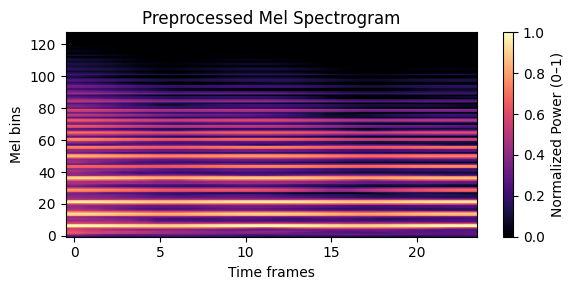

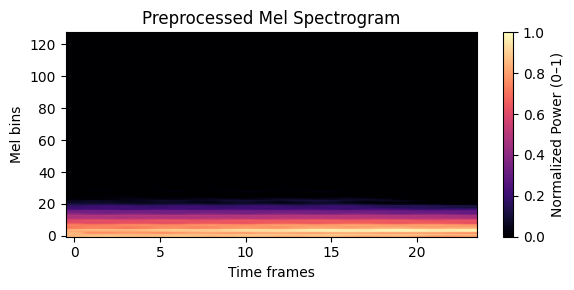

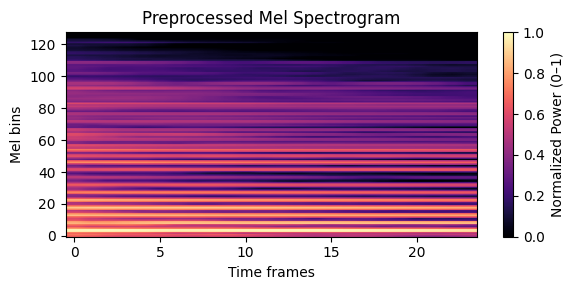

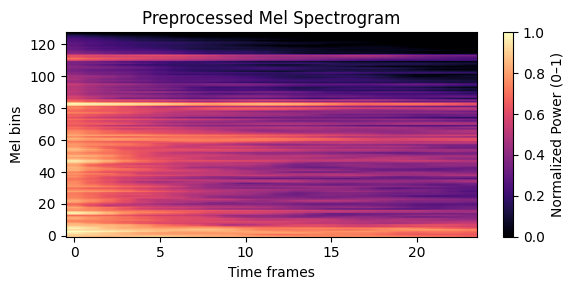

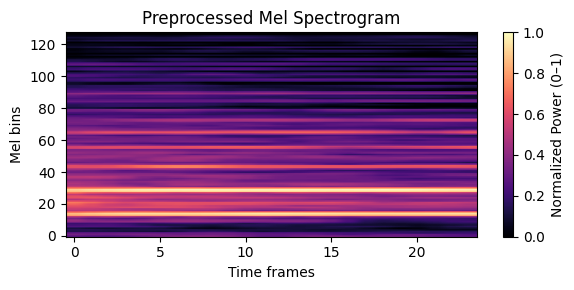

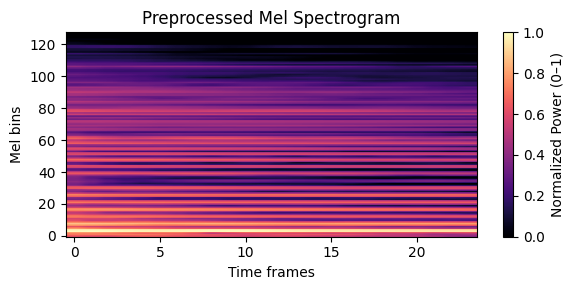

In [36]:
for i in range(12,18):
    show_preprocessed_mel(X_val[i])

In [37]:
X_train[0].shape

(128, 24, 1)

In [38]:
import numpy as np

np.savez("dataset.npz",
         X_train=X_train,
         y_train=y_train,
         X_val=X_val,
         y_val=y_val,
         X_test=X_test,
         y_test=y_test)

In [39]:
# data = np.load("dataset.npz")

# X_train = data["X_train"]
# y_train = data["y_train"]
# X_val   = data["X_val"]
# y_val   = data["y_val"]
# X_test  = data["X_test"]
# y_test  = data["y_test"]

In [40]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_dual_head_cnn(input_shape=(128, 24, 1), num_octaves=8, num_offsets=12):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    # Octave head
    octave_output = layers.Dense(num_octaves, activation='softmax', name='octave')(x)

    # Offset head
    offset_output = layers.Dense(num_offsets, activation='softmax', name='offset')(x)

    model = models.Model(inputs=inputs, outputs=[octave_output, offset_output])

    return model

In [41]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Split y_train
y_octave_train = y_train // 12
y_offset_train = y_train % 12

y_octave_val = y_val // 12
y_offset_val = y_val % 12

# Build the model
model = build_dual_head_cnn(input_shape=(128, 24, 1), num_octaves=8, num_offsets=12)

# Compile
model.compile(
    optimizer='adam',
    loss={'octave': 'sparse_categorical_crossentropy', 'offset': 'sparse_categorical_crossentropy'},
    metrics={'octave': 'accuracy', 'offset': 'accuracy'}
)

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

# Fit
history = model.fit(
    X_train, {'octave': y_octave_train, 'offset': y_offset_train},
    validation_data=(X_val, {'octave': y_octave_val, 'offset': y_offset_val}),
    batch_size=64,
    epochs=50,
    callbacks=callbacks
)

I0000 00:00:1752314297.414084      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752314297.414707      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/50


I0000 00:00:1752314304.228059     148 service.cc:148] XLA service 0x7c5150010b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752314304.229374     148 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752314304.229394     148 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752314304.718101     148 cuda_dnn.cc:529] Loaded cuDNN version 90300


 22/696 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 4.5355 - octave_accuracy: 0.1586 - octave_loss: 2.0443 - offset_accuracy: 0.0661 - offset_loss: 2.4912      

I0000 00:00:1752314309.507770     148 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


696/696 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 4.0147 - octave_accuracy: 0.3736 - octave_loss: 1.5442 - offset_accuracy: 0.1031 - offset_loss: 2.4706 - val_loss: 2.7926 - val_octave_accuracy: 0.6806 - val_octave_loss: 0.8253 - val_offset_accuracy: 0.2925 - val_offset_loss: 1.9655
Epoch 2/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 2.7878 - octave_accuracy: 0.6700 - octave_loss: 0.8380 - offset_accuracy: 0.2932 - offset_loss: 1.9498 - val_loss: 2.3618 - val_octave_accuracy: 0.7291 - val_octave_loss: 0.7352 - val_offset_accuracy: 0.4151 - val_offset_loss: 1.6280
Epoch 3/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 2.3498 - octave_accuracy: 0.7119 - octave_loss: 0.7378 - offset_accuracy: 0.4126 - offset_loss: 1.6120 - val_loss: 2.0340 - val_octave_accuracy: 0.7547 - val_octave_loss: 0.7012 - val_offset_accuracy: 0.5081 - val_offset_loss: 1.3365
Epoch 4/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 2.0850 - octave_accuracy: 0.7504 - octave_loss: 0.6707 - offset_acc

In [42]:
import tensorflow as tf
from tensorflow.keras import layers, models

def conv_block(x, filters, kernel_size=(3,3), pool=True):
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    if pool:
        x = layers.MaxPooling2D((2,2))(x)
    return x

def build_deep_dual_head_model(input_shape=(128, 24, 1), num_octaves=8, num_offsets=12):
    inputs = layers.Input(shape=input_shape)

    x = conv_block(inputs, 32)     # (64, 12)
    x = conv_block(x, 64)          # (32, 6)
    x = conv_block(x, 128)         # (16, 3)

    # Residual-style block 1
    residual = x
    x = conv_block(x, 128, pool=False)
    x = layers.Add()([x, residual])
    x = layers.Activation('relu')(x)

    # Residual-style block 2
    residual = x
    x = conv_block(x, 128, pool=False)
    x = layers.Add()([x, residual])
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    # Dual heads
    octave_out = layers.Dense(num_octaves, activation='softmax', name='octave')(x)
    offset_out = layers.Dense(num_offsets, activation='softmax', name='offset')(x)

    model = models.Model(inputs=inputs, outputs=[octave_out, offset_out])
    return model

In [44]:
model2 = build_deep_dual_head_model()

model2.compile(
    optimizer='adam',
    loss={
        'octave': 'sparse_categorical_crossentropy',
        'offset': 'sparse_categorical_crossentropy',
    },
    metrics={
        'octave': 'accuracy',
        'offset': 'accuracy',
    }
)

In [45]:
model2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 24,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 128, 24,   │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 24,   │        128 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 128, 24,   │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 24,   │        128 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 12,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 12,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 12,    │        256 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 12,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 12,    │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 6, 64) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 6,     │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 6,     │        512 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 32, 6,     │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 6,     │        512 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 3,     │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 16, 3,     │    147,584 │ max_pooling2d_7[

 Total params: 919,796 (3.51 MB)

 Trainable params: 917,364 (3.50 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [46]:
history = model2.fit(
    X_train,
    {'octave': y_octave_train, 'offset': y_offset_train},
    validation_data=(X_val, {'octave': y_octave_val, 'offset': y_offset_val}),
    batch_size=64,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
696/696 ━━━━━━━━━━━━━━━━━━━━ 45s 38ms/step - loss: 2.5985 - octave_accuracy: 0.6797 - octave_loss: 0.9199 - offset_accuracy: 0.4685 - offset_loss: 1.6786 - val_loss: 0.6780 - val_octave_accuracy: 0.9205 - val_octave_loss: 0.2853 - val_offset_accuracy: 0.8827 - val_offset_loss: 0.3933
Epoch 2/100
696/696 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 0.5549 - octave_accuracy: 0.9126 - octave_loss: 0.2851 - offset_accuracy: 0.9212 - offset_loss: 0.2697 - val_loss: 0.5211 - val_octave_accuracy: 0.9272 - val_octave_loss: 0.2387 - val_offset_accuracy: 0.9178 - val_offset_loss: 0.2902
Epoch 3/100
696/696 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 0.3667 - octave_accuracy: 0.9380 - octave_loss: 0.2028 - offset_accuracy: 0.9535 - offset_loss: 0.1639 - val_loss: 0.5163 - val_octave_accuracy: 0.9367 - val_octave_loss: 0.2320 - val_offset_accuracy: 0.9286 - val_offset_loss: 0.2893
Epoch 4/100
696/696 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.2874 - octave_accuracy: 0.9519 - octave_loss

In [48]:
y_octave_test = y_test // 12
y_offset_test = y_test % 12
model2.evaluate(
    X_test,
    {'octave': y_octave_test, 'offset': y_offset_test},
    batch_size=64
)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.4260 - octave_accuracy: 0.9387 - octave_loss: 0.2772 - offset_accuracy: 0.9660 - offset_loss: 0.1496


[0.4717758297920227,
 0.28834086656570435,
 0.18940599262714386,
 0.945040225982666,
 0.959785521030426]